<a href="https://colab.research.google.com/github/noey00/noey00/blob/main/Law_MRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install tokenizers
!pip install transformers
!pip install bert-tokenizer
!pip install wget

In [2]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

MAX_LEN = 450
EPOCHS = 10
VERBOSE = 5
BATCH_SIZE = 10

In [4]:
DATA_OUT_PATH = './data_out/KOR'

In [5]:
def plot_graphs(history, string, string_1, string_2):
    # loss 
    plt.plot(history.history[string])
    plt.plot(history.history[string_1])
    plt.plot(history.history[string_2])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string_1, string_2])
    plt.show()

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [7]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)
save_path = "bert-base-multilingual-cased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)

In [8]:
train_data = json.load(open('train_data.json'))
eval_data = json.load(open('eval_data.json'))

In [9]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-config.json'

In [10]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')

In [11]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-tf_model.h5'

In [12]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')

In [13]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data:
        context = item['context']
        question = item['question']
        answer_text = item['answer_text']
        start_char_idx = item['answer_start']
        squad_eg = SquadExample(question, context, start_char_idx, answer_text)
        squad_eg.preprocess()
        squad_examples.append(squad_eg)
    return squad_examples

def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [14]:
with open('train_data.json') as f:
    raw_train_data = json.load(f)

with open('eval_data.json') as f:
    raw_eval_data = json.load(f)

train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

200 training points created.
199 evaluation points created.


In [15]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBERTQuestionAnswering, self).__init__()
        
        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
        self.flatten = tf.keras.layers.Flatten() 
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)
        
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)
        
        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)
        
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)
    
        return start_probs, end_probs

In [16]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/',dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Some layers from the model checkpoint at ./bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ./bert-base-multilingual-cased/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
def normalized_answer(s):    
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text) 
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)   
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)  
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [18]:
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = normalized_answer(squad_eg.answer_text)
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [19]:
exact_match_callback = ExactMatch(x_eval, y_eval)

In [20]:
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [21]:
model_name = "tf2_bert_korquad"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

./data_out/KOR/tf2_bert_korquad -- Folder already exists 



In [22]:
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback, cp_callback]
)

Epoch 1/10


4/4 [==============================] - 7s 842ms/step



epoch=1, exact match score=0.23
Epoch 2/10
4/4 [==============================] - 4s 862ms/step



epoch=2, exact match score=0.31
Epoch 3/10
4/4 [==============================] - 4s 871ms/step



epoch=3, exact match score=0.41
Epoch 4/10
4/4 [==============================] - 4s 859ms/step



epoch=4, exact match score=0.39
Epoch 5/10
4/4 [==============================] - 4s 858ms/step



epoch=5, exact match score=0.38
Epoch 6/10
4/4 [==============================] - 4s 852ms/step



epoch=6, exact match score=0.38
Epoch 7/10
4/4 [==============================] - 4s 852ms/step



epoch=7, exact match score=0.38
Epoch 8/10
4/4 [==============================] - 4s 855ms/step



epoch=8, exact match score=0.38
Epoch 9/10
4/4 [==============================] - 4s 858ms/step



epoch=9, exact match score=0.38
Epoch 10/10
4/4 [==============================] - 4s 862ms/step



epoch=10, exact match score=0.38


In [23]:
print(history.history)

{'loss': [4.9918622970581055, 1.2425916194915771, 0.849779486656189, 0.4644661545753479, 0.29498860239982605, 0.23932622373104095, 0.18050959706306458, 0.10005870461463928, 0.12719403207302094, 0.08809970319271088], 'output_1_loss': [2.536306381225586, 0.6283454895019531, 0.4134150743484497, 0.22991985082626343, 0.1473352313041687, 0.09661245346069336, 0.06175560504198074, 0.05237669125199318, 0.058297500014305115, 0.04446101933717728], 'output_2_loss': [2.4555559158325195, 0.6142461895942688, 0.43636444211006165, 0.23454627394676208, 0.14765334129333496, 0.1427137702703476, 0.11875397711992264, 0.0476820208132267, 0.06889653950929642, 0.043638672679662704]}


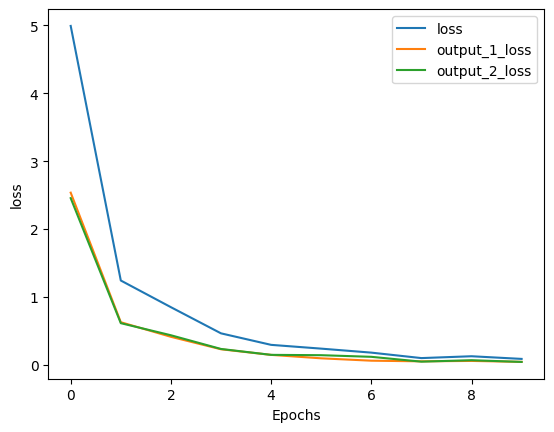

In [24]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')

In [25]:
class SquadExampl: 
    def __init__(self, question, context):
        self.question = question
        self.context = context
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())


        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask


def create_squad_examples(data):
    squad_examples = []
    for i in range(0,len(data)):
        context = data[0]
        question = data[1]
        squad_eg = SquadExampl(
            question, context
        )
        squad_eg.preprocess()
        squad_examples.append(squad_eg)
    return squad_examples


def create_inputs(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    return x

In [43]:
tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)
context = ('어린이집은 다음의 인원을 보육할 수 있는 시설을 갖추어야 하며, 정원은 총 300명을 초과할 수 없다. 가. 국공립어린이집: 상시 영유아 11명 이상 나. 직장어린이집: 상시 영유아 5명 이상 다. 사회복지법인어린이집, 법인ᆞ단체등어린이집 및 민간어린이집: 상시 영유아 21명 이상 라. 가정어린이집: 상시 영유아 5명 이상 20명 이하 마. 협동어린이집: 상시 영유아 11명 이상')
question = ('어린이집의 최대 보육 인원은?')
data = [context,question]

squad_examples = create_squad_examples(data)
x = create_inputs(squad_examples)

In [44]:
start, end = korquad_model.predict(x)

1/1 [==============================] - 0s 207ms/step


In [ ]:
print(start[0])

In [49]:
start_index = np.argmax(start[1]-1)
end_index = np.argmax(end[1]-1)
print(start_index,end_index)

26 27


In [50]:
# 넘파이 배열에서 최댓값의 인덱스를 추출합니다.
start_index = np.argmax(start[0])
end_index= np.argmax(end[0])

answer = context[start_index: end_index+1]

# 최종 답변을 출력합니다.
print("본문:", context)
print("질문:", question)
print("답변:", answer)

본문: 어린이집은 다음의 인원을 보육할 수 있는 시설을 갖추어야 하며, 정원은 총 300명을 초과할 수 없다. 가. 국공립어린이집: 상시 영유아 11명 이상 나. 직장어린이집: 상시 영유아 5명 이상 다. 사회복지법인어린이집, 법인ᆞ단체등어린이집 및 민간어린이집: 상시 영유아 21명 이상 라. 가정어린이집: 상시 영유아 5명 이상 20명 이하 마. 협동어린이집: 상시 영유아 11명 이상
질문: 어린이집의 최대 보육 인원은?
답변:  갖
